<a href="https://colab.research.google.com/github/Anastasiya9323/machineLearning/blob/main/firstAttempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
len(y_train), len(y_test)

(60000, 10000)

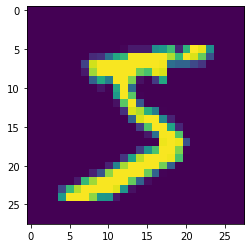

tensor(5)


In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [7]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [9]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [11]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [12]:
batch_size = 100

train_accuracy_history = []
train_loss_history = []

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)
best_accuraccy = 0

for epoch in range(400):
    order = np.random.permutation(len(X_train))
    train_preds = torch.zeros([X_train.shape[0], 10], dtype=torch.float)
    train_batch_loss_history = []
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()

        train_batch_loss_history.append(loss_value.tolist())
        train_preds[batch_indexes] = preds.cpu()
        
        optimizer.step()
        
    train_loss_history.append(np.mean(train_batch_loss_history))
    
    accuracy_train = (train_preds.argmax(dim=1) == y_train).float().mean().cpu()
    train_accuracy_history.append(accuracy_train)
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print((epoch+1),": ",accuracy)
    if accuracy  > best_accuraccy:
        best_accuraccy = accuracy 
print(best_accuraccy)

1 :  tensor(0.9750)
2 :  tensor(0.9828)
3 :  tensor(0.9859)
4 :  tensor(0.9874)
5 :  tensor(0.9888)
6 :  tensor(0.9881)
7 :  tensor(0.9853)
8 :  tensor(0.9884)
9 :  tensor(0.9887)
10 :  tensor(0.9882)
11 :  tensor(0.9883)
12 :  tensor(0.9900)
13 :  tensor(0.9874)
14 :  tensor(0.9895)
15 :  tensor(0.9895)
16 :  tensor(0.9881)
17 :  tensor(0.9881)
18 :  tensor(0.9887)
19 :  tensor(0.9871)
20 :  tensor(0.9870)
21 :  tensor(0.9883)
22 :  tensor(0.9882)
23 :  tensor(0.9883)
24 :  tensor(0.9892)
25 :  tensor(0.9885)
26 :  tensor(0.9880)
27 :  tensor(0.9893)
28 :  tensor(0.9876)
29 :  tensor(0.9890)
30 :  tensor(0.9897)
31 :  tensor(0.9868)
32 :  tensor(0.9880)
33 :  tensor(0.9898)
34 :  tensor(0.9860)
35 :  tensor(0.9875)
36 :  tensor(0.9882)
37 :  tensor(0.9886)
38 :  tensor(0.9880)
39 :  tensor(0.9885)
40 :  tensor(0.9889)
41 :  tensor(0.9909)
42 :  tensor(0.9895)
43 :  tensor(0.9891)
44 :  tensor(0.9887)
45 :  tensor(0.9888)
46 :  tensor(0.9883)
47 :  tensor(0.9867)
48 :  tensor(0.9888)
4

In [13]:
lenet5.forward(X_test)

tensor([[ -7.5928,   0.9560,   2.2250,  ...,  28.2814, -10.9456,   8.6671],
        [  4.7186,  -1.4784,  33.2562,  ...,  -7.5548,   4.9233,  -9.5764],
        [ -8.3050,  28.9606,   0.3376,  ...,  -0.1880,   7.0821, -11.9325],
        ...,
        [-13.3106,  -5.2516,  -6.7549,  ...,   1.8839,  -0.9915,   9.3223],
        [ -3.0588,  -2.8782, -11.4624,  ...,  -7.7178,   6.3286,  -7.6063],
        [  6.3961,  -8.6528,   3.9845,  ..., -15.4465,   5.3385, -12.3225]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

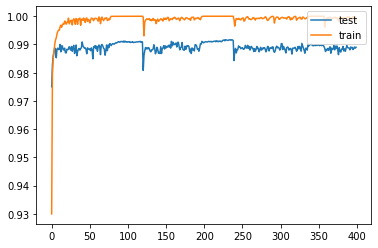

In [14]:
plt.plot(test_accuracy_history,label='test')
plt.plot(train_accuracy_history,label='train')
plt.legend(loc='upper right')

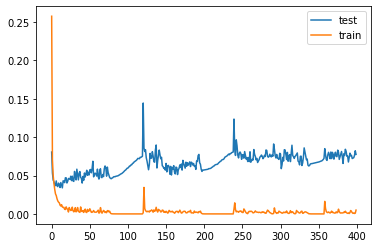

In [15]:
plt.plot(test_loss_history,label='test');
plt.plot(train_loss_history,label='train');
plt.legend(loc='upper right')